In [1]:
from lips import get_root_path
from lips.dataset import airfransDataSet
from lips.dataset.airfransDataSet import AirfRANSDataSet
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from torch import nn

from airfrans.simulation import Simulation
import pyvista as pv

import xgboost as xgb

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = '../../Airfrans/Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"
BENCH_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","simulators","torch_fc.ini") #Configuration file re
# print(BENCH_CONFIG_PATH)

# Scalers
PRESS_SCALE = 1600.0
TURB_SCALE = 0.01
SPEED_SCALE = 75.0
DEFAULT_SCALE = 1.0


In [3]:
benchmark=AirfRANSBenchmark(benchmark_path = DIRECTORY_NAME,
                            config_path = BENCH_CONFIG_PATH,
                            benchmark_name = BENCHMARK_NAME,
                            log_path = LOG_PATH)
benchmark.load(path=DIRECTORY_NAME)

Loading dataset (task: reynolds, split: test): 100%|██████████| 496/496 [01:09<00:00,  7.10it/s]


In [4]:
# Create normalizing constants
MEANS = {}
STDS = {}

for var in ['x-position', 'y-position', 'x-inlet_velocity', 'x-velocity', 'pressure', 'turbulent_viscosity']:
    MEANS[var] = np.mean(benchmark.train_dataset.data[var])
    STDS[var] = np.std(benchmark.train_dataset.data[var])

MEANS['speed'] = MEANS['x-inlet_velocity']
STDS['speed'] = STDS['x-inlet_velocity']
MEANS['position'] = 0.0
STDS['position'] = STDS['x-position']

for var in ['x-position', 'y-position', 'x-inlet_velocity', 'x-velocity']:
    MEANS.pop(var, None)
    STDS.pop(var, None)

print(MEANS)
print(STDS)

x_means = np.zeros(2, dtype=np.float32)
x_stds = np.zeros(2, dtype=np.float32)
y_means = np.zeros(4, dtype=np.float32)
y_stds = np.zeros(4, dtype=np.float32)

for i, var in zip(range(2), ['position', 'speed']):        
    x_means[i] = MEANS[var]
    x_stds[i] = STDS[var]

for i, var in zip(range(4), ['position', 'speed', 'pressure', 'turbulent_viscosity']):        
    y_means[i] = MEANS[var]
    y_stds[i] = STDS[var]


{'pressure': -395.22959540860137, 'turbulent_viscosity': 0.0008392954292084482, 'speed': 63.15423170302567, 'position': 0.0}
{'pressure': 2425.738434726353, 'turbulent_viscosity': 0.0030420989011928183, 'speed': 8.487422521188462, 'position': 0.7044480333506549}


In [40]:
# Edge functions

import torch
from torch_geometric.data import Data

# Create label and data array for single edge
def make_edge(a, b):
    label = str(a) + '_' + str(b)
    return label, np.array([a,b], dtype=int)


# Line from a to b
def delta_vector(from_v, to_v):
    return to_v-from_v

def angle_off_x_axis(a):
    # Note that both vectors begin at the origin, so we actually want them compared vs. [1,0]
    # if len(a.shape) < 2:
    #     a = np.expand_dims(a, 1)
    if len(a.shape) < 2:
        norm = np.linalg.norm(a)
        out = np.ones_like(norm)
        out = np.arccos(np.divide(a.dot(np.array([1,0])),norm))

    else:
        norm = np.linalg.norm(a, axis=1)
        out = np.ones_like(norm)
        out[np.where(norm > 0)] = np.arccos(np.divide(np.squeeze(a[np.where(norm > 0)]).dot(np.array([1,0])),np.squeeze(norm[np.where(norm > 0)])))
    return out

# Create all edges
def make_edges(sim):
    cells = sim.internal.cells_dict[9]

    edge_dict = {}
    for cell in cells:
        # Create fully connected mesh, including diagonals
        for i in range(0, 4):
            for j in range(0, 4):
                if i == j: 
                    continue
                label, data = make_edge(cell[i], cell[j])
                if label not in edge_dict:
                    edge_dict[label] = data # Push the edge

    # Store de-duplicated bidirectional edges in numpy format
    edge_index = np.zeros((2,len(edge_dict)), dtype=np.intc)
    edge_features = np.zeros((len(edge_dict),2), dtype=np.float32)

    for i, edge in zip(range(0, len(edge_dict)), edge_dict.values()):
        edge_index[:,i] = edge
        edge_features[i,0] = np.sqrt(np.sum([sim.position[edge[0]]**2, sim.position[edge[1]]**2]))
        # print(angle_off_x_axis(delta_vector(sim.position[edge[0]], sim.position[edge[1]])))
        edge_features[i,1] = angle_off_x_axis(delta_vector(sim.position[edge[0]], sim.position[edge[1]]))
    
    return edge_index, edge_features

In [25]:
# Dataset preparation 

from tqdm import tqdm
from torch_geometric.data import InMemoryDataset, Dataset
import os
from scipy.spatial.distance import cdist


class AirFransGeo():
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
        self.data = []
        for i in tqdm(indices):
            sim = Simulation(DIRECTORY_NAME, self.dataset.extra_data['simulation_names'][i,0])
            # sim = extract_dataset_by_simulation('sim', self.dataset, i)
            # global_x = sim.input_velocity # These are global inputs for each node in the mesh
            inlet_speed = np.linalg.norm(sim.input_velocity, axis=1)
            inlet_theta = angle_off_x_axis(sim.input_velocity)

            # Negate the angles if y < 0
            inlet_theta[np.where(sim.input_velocity[:,1] < 0)] *= -1.0

            # X position
            position = (sim.position - MEANS['position']) / STDS['position']

            # global_x = (global_x - MEANS['speed']) / STDS['speed']
            inlet_speed = (inlet_speed - MEANS['speed']) / STDS['speed']

            # Find closest airfoil points
            surface = np.hstack([sim.position[sim.surface], sim.normals[sim.surface]])
            dists = cdist(sim.position, surface[:,:2], metric='euclidean')
            best_idx = np.argmin(dists,axis=1).T.tolist()
            closest_surfaces = np.take(surface, best_idx, axis=0)

            # Vector to closest airfoil point
            vector_to_surface = delta_vector(sim.position, closest_surfaces[:,:2])
            vector_to_surface = (vector_to_surface - MEANS['position']) / STDS['position']

            # Angle (relative to x-axis) to closest airfoil point
            surface_theta = angle_off_x_axis(delta_vector(sim.position, closest_surfaces[:,:2]))

            # Airfoil distance
            surface_distance = (sim.sdf - MEANS['position']) / STDS['position']

            # Is_airfoil
            is_airfoil = sim.surface.astype(np.float32)

            # Y Outlet speed
            outlet_speed = np.linalg.norm(sim.velocity, axis=1)
            outlet_speed = (outlet_speed - MEANS['speed']) / STDS['speed']

            # Y Outlet theta
            outlet_theta = angle_off_x_axis(sim.velocity)
            outlet_theta[np.where(sim.velocity[:,1] < 0)] *= -1.0

            # Y Pressure
            outlet_pressure = (sim.pressure - MEANS['pressure']) / STDS['pressure']

            # Y Turb
            outlet_turb = (sim.nu_t - MEANS['turbulent_viscosity']) / STDS['turbulent_viscosity']

            # X and Y coordinates of each point as well as normals (when on airfoil)
            x = np.hstack([position, np.expand_dims(inlet_speed,1), 
                        np.expand_dims(inlet_theta,1), np.expand_dims(is_airfoil,1),
                         vector_to_surface, np.expand_dims(surface_theta,1), surface_distance]) 
            y = np.hstack([np.expand_dims(outlet_speed,1), np.expand_dims(outlet_theta,1), outlet_pressure, outlet_turb])
            edge_index, edge_attr = make_edges(sim)            

            instance = Data(x=torch.from_numpy(x.astype(np.float32)), edge_index=torch.from_numpy(edge_index),
                    edge_attr=torch.from_numpy(edge_attr.astype(np.float32)), y=torch.from_numpy(y.astype(np.float32)), 
                    pos=torch.from_numpy(sim.position.astype(np.float32)))
            self.data.append(instance)

    def len():
        return len(indices)

    def get(self,index):
        return self.data[index]

# Make train and CV splits
cv_indices = list(np.array(range(1,int(103/5)),dtype=np.intc)*5)
train_indices = []
for i in range(0,103):
    if i not in cv_indices:
        train_indices.append(i)


In [64]:
# Load datasets

import pickle

TRUNCATED = False
REFRESH = False

if os.path.exists('train.pkl') and not REFRESH:
    file = open('train.pkl', 'rb')
    train = pickle.load(file)
    file.close()
    file = open('cv.pkl', 'rb')
    cv = pickle.load(file)
    file.close()
else:

    if TRUNCATED:
        train = AirFransGeo(benchmark.train_dataset, train_indices[:4])
        cv = AirFransGeo(benchmark.train_dataset, cv_indices[:4])
    else:
        train = AirFransGeo(benchmark.train_dataset, train_indices)
        cv = AirFransGeo(benchmark.train_dataset, cv_indices)


In [42]:
import pickle

file = open(os.path.join('train.pkl'), 'wb')
pickle.dump(train, file)
file.close()
file = open(os.path.join('cv.pkl'), 'wb')
pickle.dump(cv, file)
file.close()

In [65]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train.data, shuffle=True, batch_size=5)
cv_loader = DataLoader(cv.data, shuffle=True, batch_size=5)

In [44]:

device = torch.device('cuda')


In [67]:
import torch.nn.functional as F
from torch.nn import Linear, GELU
from torch_geometric.nn import GCNConv, GATConv

FEATS = 9
NODES = 16
OUTPUTS = 4

CONV_LAYERS = 16

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = Linear(FEATS, NODES)
        self.gelu = GELU()
        # self.conv_layers = nn.ModuleList([GCNConv(NODES, NODES)]*CONV_LAYERS)
        self.conv_layers = nn.ModuleList([GATConv(NODES, NODES, edge_dim=2)]*CONV_LAYERS)
        # self.final = GCNConv(NODES, OUTPUTS)
        self.final = GATConv(NODES, OUTPUTS, edge_dim=2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.lin1(x)
        x = self.gelu(x)
        for layer in self.conv_layers:
            x = layer(x, edge_index)
        x = self.final(x, edge_index)


        return x

In [68]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

EPOCHS = 10000

model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
# scaler = torch.tensor([SPEED_SCALE, SPEED_SCALE, PRESS_SCALE, TURB_SCALE]).to(device)
# x_scaler.to(device)
# loss_fn = torch.nn.MSELoss()

def loss_fn(y_pred, y_true):
    losses = []
    overall_loss = torch.tensor(0.0).to(y_pred.device)
    base_fn = torch.nn.MSELoss()
    for i in range(y_pred.shape[1]):
        losses.append(base_fn(y_pred[:,i], y_true[:,i]))
        overall_loss += losses[-1]
    losses.append(overall_loss)
    return losses

losstypes = ['loss_speed', 'loss_theta', 'loss_press', 'loss_turb', 'loss_train']

def train_one_epoch(model, optimizer, train_loader, device, scaler, losstypes, loss_fn, epoch):

    # Initiatlize losses to empty
    losses={}
    for loss in losstypes:
        losses[loss] = []

    for batch in train_loader:
        optimizer.zero_grad()

        out = model(batch.to(device))
        # y_true = torch.divide(batch.y, scaler)
        y_true = batch.y
        loss_speed, loss_theta, loss_press, loss_turb, loss_train = loss_fn(out, y_true)
        for loss in losstypes:
            losses[loss].append(eval(loss))
        loss_train.backward()
        optimizer.step()

    # Wrap up epoch
    avg_losses = {}
    for loss in losstypes:
        avg_losses[loss] = torch.mean(torch.tensor(losses[loss])).detach().cpu().item()
    print("Epoch " + str(epoch))
    loss_str = "T Losses "
    for loss in losstypes:
        loss_str += ' ' + loss + ':' + "{:10.4f}".format(avg_losses[loss])
    # print("Losses " + [[loss, avg_losses[loss]].join(': ') for loss in losstypes].join(' '))
    print(loss_str)
    for loss in losstypes:
        writer.add_scalar("train/" + loss, avg_losses[loss], epoch)

def validation_loop(model, cv_loader, device, scaler, losstypes, loss_fn):
    # Initiatlize losses to empty
    losses = {}
    for loss in losstypes:
        losses[loss] = []

    with torch.no_grad():
        for batch in cv_loader:
            out = model(batch.to(device))
            # y_true = torch.divide(batch.y, scaler)
            y_true = batch.y
            loss_speed, loss_theta, loss_press, loss_turb, loss_cv = loss_fn(out, y_true)
            for loss in losstypes:
                losses[loss].append(eval(loss).item())

    # Wrap up CV
    avg_losses = {}
    for loss in losstypes:
        avg_losses[loss] = torch.mean(torch.tensor(losses[loss])).detach().cpu().item()
    loss_str = " C Losses "
    for loss in losstypes:
        loss_str += ' ' + loss + ':' + "{:10.4f}".format(avg_losses[loss])
    print(loss_str)
    for loss in losstypes:
        writer.add_scalar("cv/" + loss, avg_losses[loss], epoch)

for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_loader, device, None, losstypes, loss_fn, epoch)
    cv_losses = losstypes[:-1]
    cv_losses.append('loss_cv')
    validation_loop(model, cv_loader, device, None, cv_losses, loss_fn)

# for epoch in range(EPOCHS):
#     optimizer.zero_grad()
#     for batch in train_loader:
#         out = model(batch.to(device))
#         y_true = torch.divide(batch.y, scaler)

#         loss = torch.mean(torch.subtract(out, y_true)**2)
#     print(loss.detach().cpu())
#     loss.backward()
#     optimizer.step()


Epoch 0
T Losses  loss_speed:   12.3124 loss_theta:    0.4451 loss_press:    1.1558 loss_turb:    1.0127 loss_train:   14.9260
 C Losses  loss_speed:   10.7389 loss_theta:    0.4320 loss_press:    1.0191 loss_turb:    0.5358 loss_cv:   12.7258
Epoch 1
T Losses  loss_speed:   10.7783 loss_theta:    0.4103 loss_press:    1.1015 loss_turb:    0.9627 loss_train:   13.2527
 C Losses  loss_speed:   10.6506 loss_theta:    0.3876 loss_press:    1.0327 loss_turb:    0.4783 loss_cv:   12.5492
Epoch 2
T Losses  loss_speed:   10.5579 loss_theta:    0.3702 loss_press:    1.0287 loss_turb:    0.9806 loss_train:   12.9374
 C Losses  loss_speed:   10.4736 loss_theta:    0.3931 loss_press:    0.9699 loss_turb:    0.5280 loss_cv:   12.3646
Epoch 3
T Losses  loss_speed:   10.2301 loss_theta:    0.3897 loss_press:    1.0162 loss_turb:    1.0223 loss_train:   12.6584
 C Losses  loss_speed:    9.7025 loss_theta:    0.3981 loss_press:    0.9396 loss_turb:    0.4701 loss_cv:   11.5103
Epoch 4
T Losses  loss_s

OutOfMemoryError: CUDA out of memory. Tried to allocate 526.00 MiB (GPU 0; 23.64 GiB total capacity; 16.04 GiB already allocated; 566.38 MiB free; 21.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [50]:
# Reconstruct an example using model predictions
with torch.no_grad():
    sample = cv.get(0)
    out = model(sample.to(device))
    # y_pred_scaled = torch.multiply(out, scaler)

        # for i in range(amin, amin+1):
        #     print(torch.multiply(out[i], scaler))
        #     print(batch.y[i])
        #     print(loss_fn(out[i], torch.divide(batch.y[i].to('cpu'), scaler)))

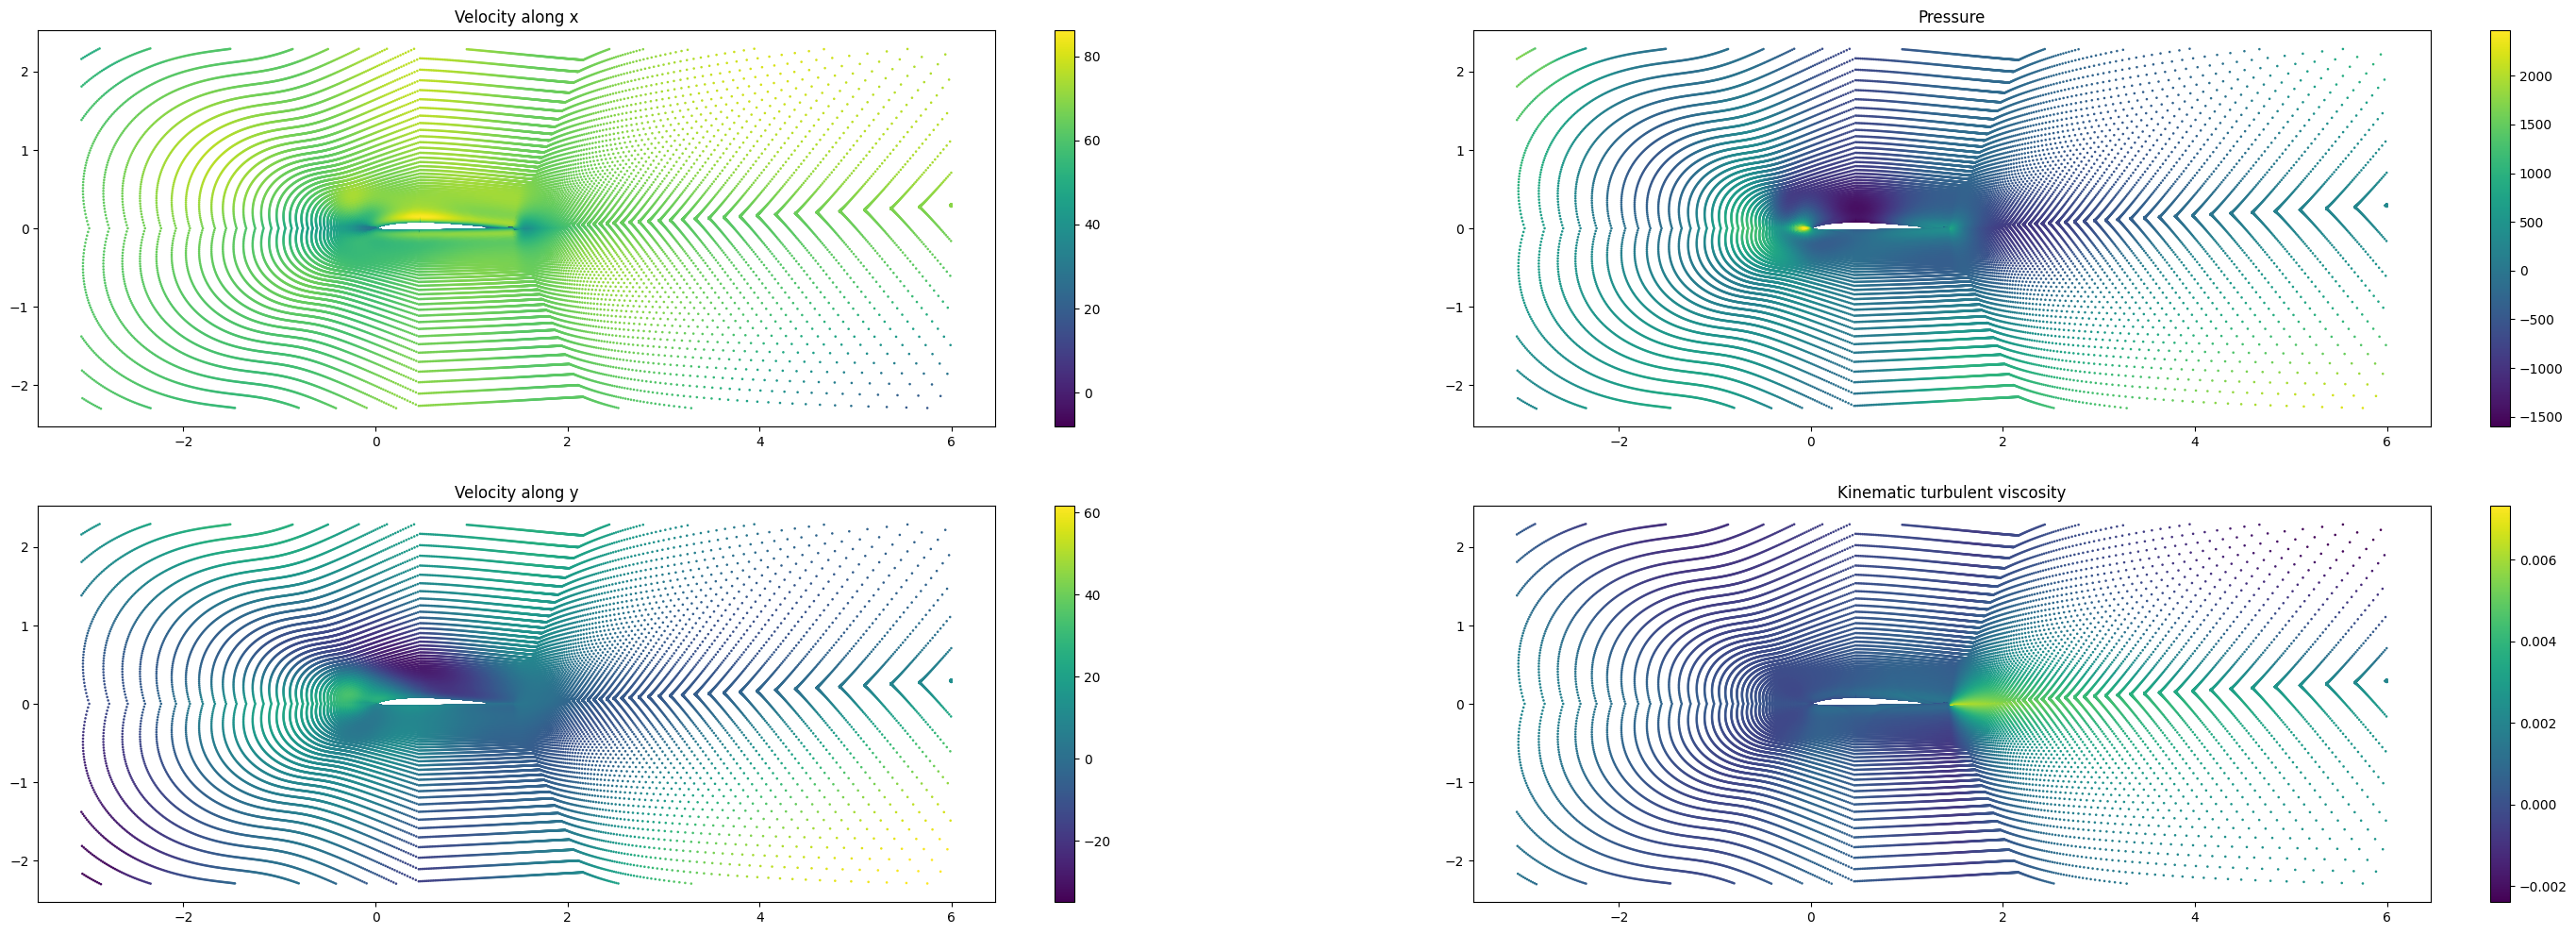

In [60]:
# x = torch.multiply(sample.x.detach().cpu(), x_scaler).numpy()
x = sample.x.detach().cpu().numpy()
y_true = sample.y.cpu().numpy()
y = out.detach().cpu().numpy()

speed = y[:,0]*STDS['speed'] + MEANS['speed']

pred_y_vel = np.zeros_like(y[:,1])
true_y_vel = np.zeros_like(y[:,1])


pred_x_vel = (np.cos(2*np.pi + y[:,1]))*speed
pred_y_vel[np.where(y[:,1]<=0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y[np.where(y[:,1]<=0),1]))),speed[np.where(y[:,1]<=0)])
pred_y_vel[np.where(y[:,1]>0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y[np.where(y[:,1]>0),1]))),speed[np.where(y[:,1]>0)])

true_x_vel = (np.cos(2*np.pi + y_true[:,1]))*speed
true_y_vel[np.where(y_true[:,1]<=0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]<=0),1]))),speed[np.where(y_true[:,1]<=0)])
true_y_vel[np.where(y_true[:,1]>0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]>0),1]))),speed[np.where(y_true[:,1]>0)])

y[:,0] = pred_x_vel
y[:,1] = pred_y_vel
y[:,2] = (y[:,2]*STDS['pressure']) + MEANS['pressure']
y[:,3] = (y[:,3]*STDS['turbulent_viscosity']) + MEANS['turbulent_viscosity']

y_true[:,0] = true_x_vel
y_true[:,1] = true_y_vel
y_true[:,2] = (y_true[:,2]*STDS['pressure']) + MEANS['pressure']
y_true [:,3] = (y_true[:,3]*STDS['turbulent_viscosity']) + MEANS['turbulent_viscosity']

fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(x[:, 0], x[:, 1], c = y[:, 0], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(x[:, 0], x[:, 1], c = y[:, 2], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(x[:, 0], x[:, 1], c = y[:, 1], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(x[:, 0], x[:, 1], c = y[:, 3], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

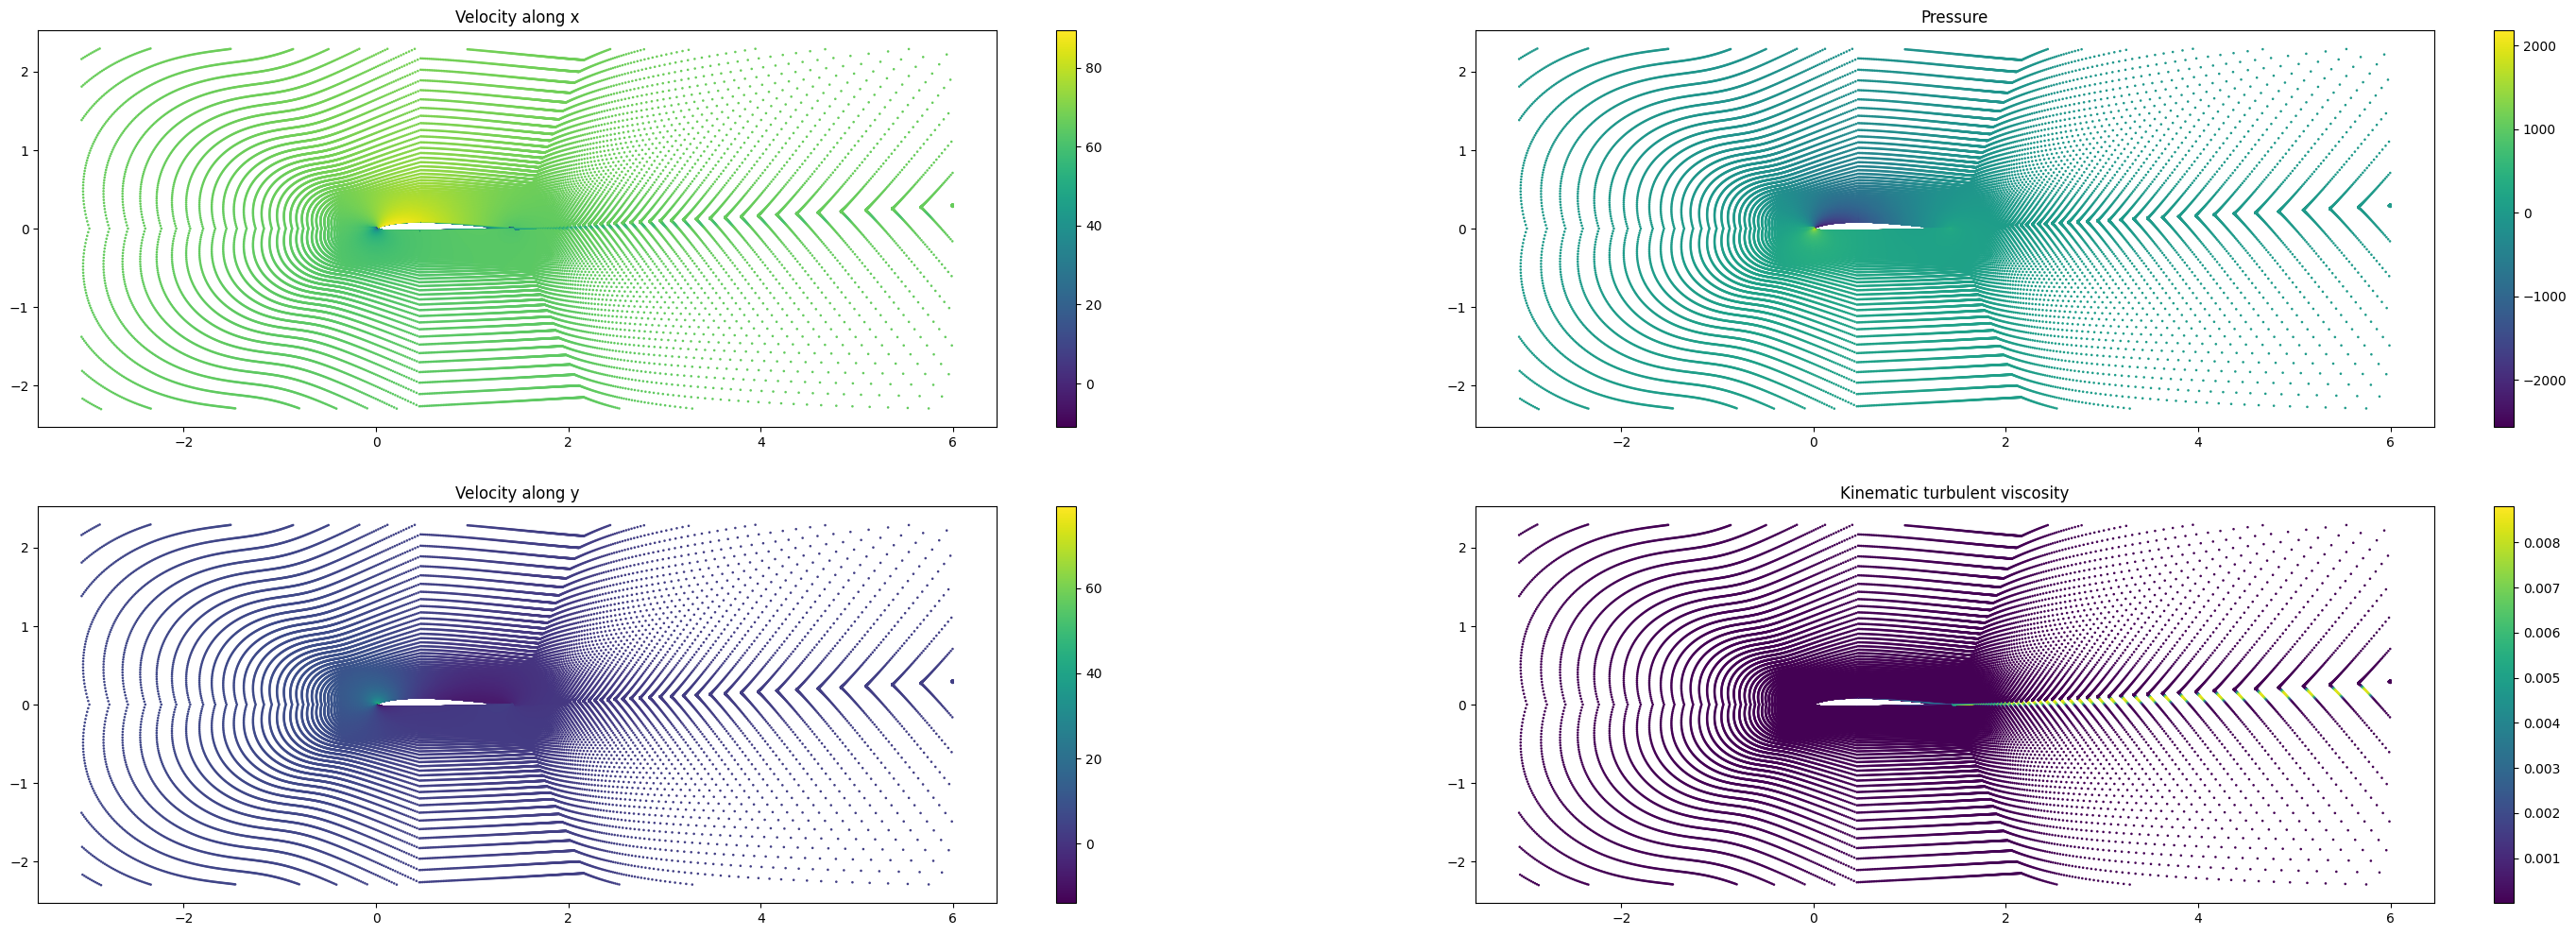

In [61]:
# x = torch.multiply(sample.x.detach().cpu(), x_scaler).numpy()
y_true = sample.y.cpu().numpy()

speed = y_true[:,0]*STDS['speed'] + MEANS['speed']

true_y_vel = np.zeros_like(y[:,1])

true_x_vel = (np.cos(2*np.pi + y_true[:,1]))*speed
true_y_vel[np.where(y_true[:,1]<=0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]<=0),1]))),speed[np.where(y_true[:,1]<=0)])
true_y_vel[np.where(y_true[:,1]>0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]>0),1]))),speed[np.where(y_true[:,1]>0)])

y_true[:,0] = true_x_vel
y_true[:,1] = true_y_vel
y_true[:,2] = (y_true[:,2]*STDS['pressure']) + MEANS['pressure']
y_true[:,3] = (y_true[:,3]*STDS['turbulent_viscosity']) + MEANS['turbulent_viscosity']

fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(x[:, 0], x[:, 1], c = y_true[:, 0], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(x[:, 0], x[:, 1], c = y_true[:, 2], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(x[:, 0], x[:, 1], c = y_true[:, 1], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(x[:, 0], x[:, 1], c = y_true[:, 3], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()